In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from loguru import logger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
#######################
## Diffusion modules ##
#######################

class Diffusion:
    '''
    This class contains these functions:
    + noise scheduler
    + noising images
    + sampling images (generate)
    '''
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        self.beta = self.noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) # Linear scheduling
    
    def noise_images(self, x, t): # nois image is x_t
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None] # the resulting shape will be (batch_size, 1, 1, 1)
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x)
        
        x_t = sqrt_alpha_hat*x + sqrt_one_minus_alpha_hat*noise
        return x_t, noise
    
    def sample_timesteps(self, n): # create the timesteps for sampling
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, save_interval=50):        
        _ = model.eval()
        with torch.inference_mode():
            x = torch.randn(size=(n, 3, self.img_size, self.img_size)).to(self.device)
            
            img_list = []
            img_list.append(x.cpu()) # Move to CPU to save GPU memory
            
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0, desc="Sampling"):
                t = (torch.ones(n) * i).long().to(self.device) # torch.ones create [1., 1., 1., ...], multiply i creates [i., i., i., ...], .long() for integer
                predicted_noise = model(x, t)                  # example, at timestep i=5, with n=3 images, the resulted t=[5, 5, 5]
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][: None, None, None]
                beta = self.beta[t][: None, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                x = (1/torch.sqrt(alpha)) * (x - ((1 - alpha)/torch.sqrt(1 - alpha_hat))*predicted_noise) +  torch.sqrt(beta)*noise
                
                # Only save every Nth frame
                if (i % save_interval == 0) or (i == 1):
                    img_list.append(x.cpu().clone())  # Move to CPU to save GPU memory
        
        _ = model.train()
        
        for idx, x in enumerate(img_list):
            img_list[idx] = (x.clamp(-1, 1) + 1) / 2   # x.clamp(-1, 1) clips all values into [-1, 1], then (x_clamp + 1)/2 to brings back to [0, 1] range
            x = img_list[idx] # update new values for x
            img_list[idx] = (x * 255).type(torch.uint8) # convert to RGB pixel values (0-255)
        
        final_image = img_list[-1]
        return final_image, img_list

In [12]:
#####################
## UNet components ##
#####################

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [13]:
#######################
## UNet architecture ##
#######################

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=256, device=device): # in_channels and out_channels are all 3 since dealing with RGB images
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        # Initial Conv
        self.initial_conv = DoubleConv(in_channels, 64)
        
        # Encoder (Down)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)
        
        # Bottle-neck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        # Decoder (Up)
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        
        # Out Conv
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def pos_encoding(self, t, channels):
        inv_freq = 1. / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float) # make t becomes column vector
        t = self.pos_encoding(t, self.time_dim)
        
        # Down
        x1 = self.initial_conv(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottle-neck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Up
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        out = self.out_conv(x)
        return out

In [36]:
###############
## Utilities ##
###############

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import plotly.graph_objects as go
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow( torch.cat([
        torch.cat([img for img in images.cpu()], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()
    
def create_diffusion_animation(img_list, fps=30, skip_frames=1):
    """
    Create animation of diffusion sampling process.
    
    Args:
        img_list: List of image tensors from sampling
        fps: Animation speed
        skip_frames: Show every Nth frame (default: 10)
    """
    # Take every Nth frame and first image from batch
    frames = []
    for i in range(0, len(img_list), skip_frames):
        img = img_list[i][0].cpu().permute(1, 2, 0).numpy()  # [3,H,W] -> [H,W,3]
        frames.append(img)
    
    # Create figure
    fig = go.Figure(
        data=[go.Image(z=frames[0])],
        layout=go.Layout(
            title="Diffusion Denoising Process",
            xaxis=dict(visible=False),
            yaxis=dict(visible=False)
        ),
        frames=[go.Frame(data=[go.Image(z=frame)]) for frame in frames]
    )
    
    # Add play button
    fig.update_layout(
        updatemenus=[{
            "buttons": [
                {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 1000/fps}}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0}, "mode": "immediate"}]}
            ],
            "type": "buttons"
        }]
    )
    
    return fig

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def get_data(img_size, batch_size, img_list=None, path=None):
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
        )
    ])
    
    if (img_list is None) and (path is None):
        logger.error("No data was given")
    
    if path is not None:
        dataset = torchvision.datasets.ImageFolder(path, transform=preprocess)
    else:
        img_transformed = torch.stack([preprocess(img) for img in img_list])
        dataset = torch.utils.data.TensorDataset(img_transformed)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [6]:
####################
## pokemon images ##
####################

import gc
gc.collect()
torch.cuda.empty_cache()

from datasets import load_dataset
pokemon = load_dataset(path="reach-vb/pokemon-blip-captions", split="train")
pokemon = pokemon['image']

Training:   0%|          | 0/500 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1 | Loss: 0.3195179459594545 | Current LR: 0.0002


Sampling: 0it [00:00, ?it/s]

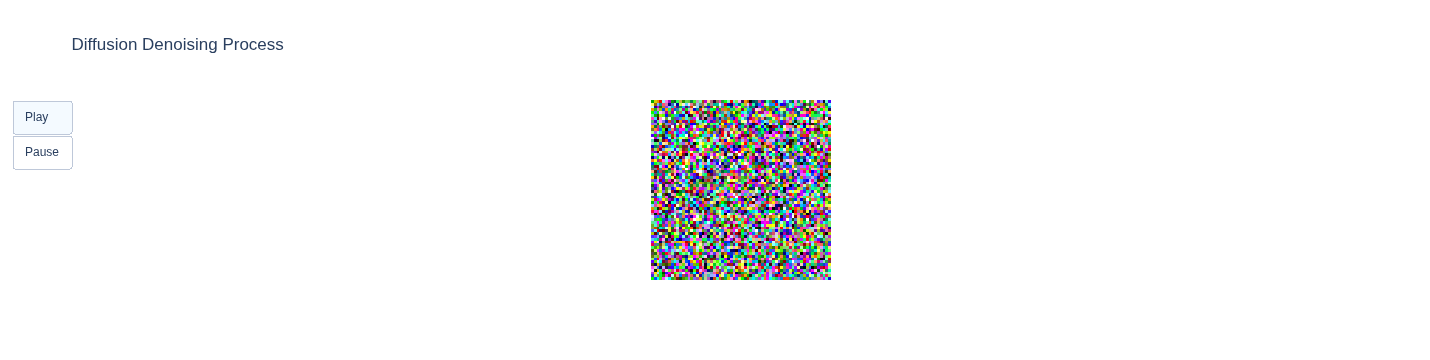

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 125 | Loss: 0.028770779168588063 | Current LR: 9.765625e-08


Sampling: 0it [00:00, ?it/s]

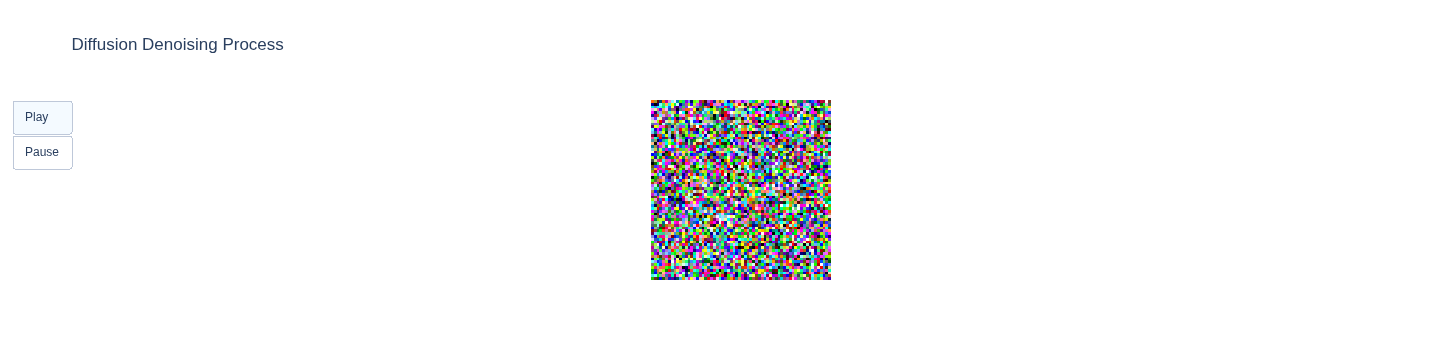

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 250 | Loss: 0.028225159600731874 | Current LR: 1.220703125e-08


Sampling: 0it [00:00, ?it/s]

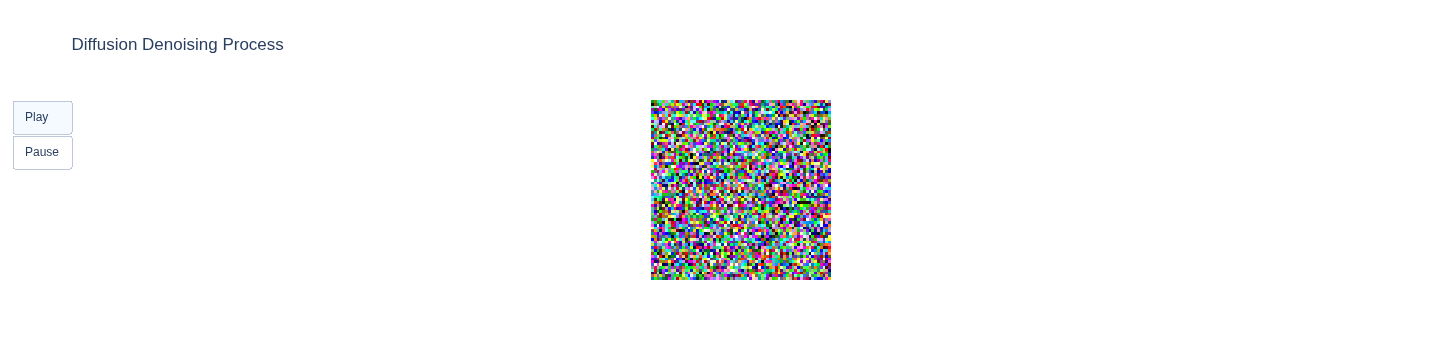

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 375 | Loss: 0.026079116566550164 | Current LR: 1.220703125e-08


Sampling: 0it [00:00, ?it/s]

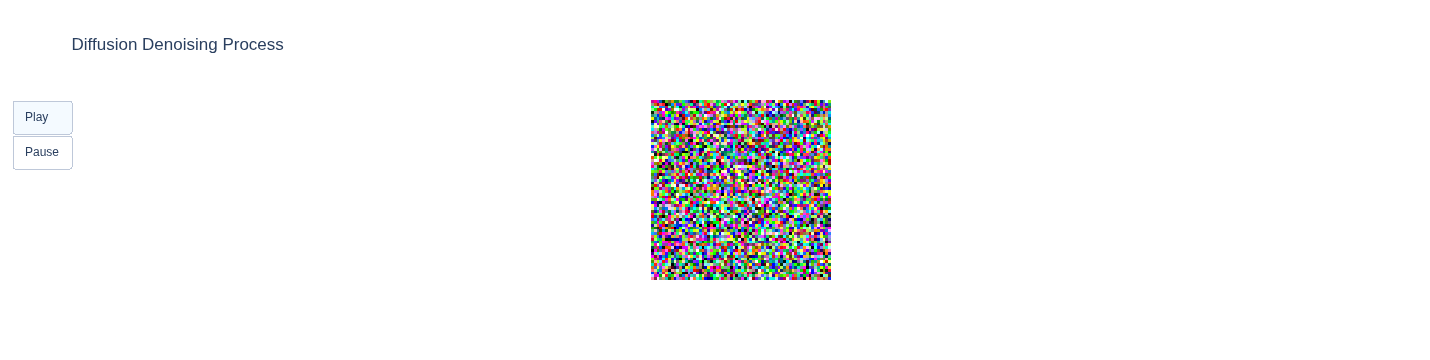

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 500 | Loss: 0.024281130864151887 | Current LR: 1.220703125e-08


Sampling: 0it [00:00, ?it/s]

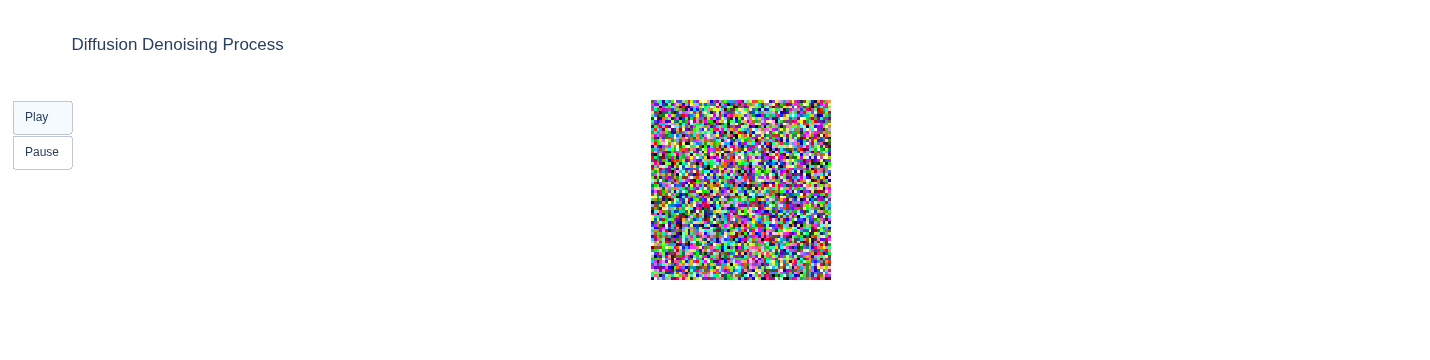

In [33]:
####################
## Trainning loop ##
####################

IMG_SIZE = 64

torch.manual_seed(42)
model = UNet().to(device=device)

def train(epochs):
    dataloader = get_data(img_size=IMG_SIZE, batch_size=8, img_list=pokemon)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=250, factor=0.8)
    loss_fn = nn.MSELoss()
    diffusion = Diffusion(img_size=IMG_SIZE, device=device)
    l = len(dataloader)

    for epoch in tqdm(range(1, epochs+1), desc="Training"):
        
        epoch_loss = 0 # Track loss to give the scheduler a meaningful average
        for i, batch in enumerate(dataloader):
        # Handle both ImageFolder (returns tuple) and TensorDataset (returns tuple)
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = loss_fn(noise, predicted_noise)
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataloader)
        
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        if (epoch == 1) or (epoch % 1000 == 0):
            print("+"*50)
            print(f"Epoch: {epoch} | Loss: {avg_loss} | Current LR: {current_lr}")
            _, img_list = diffusion.sample(model, n=1)
            fig = create_diffusion_animation(img_list)
            fig.show()

#-------
## Train
#-------

train(4000)

In [37]:
################
## Save model ##
################

path = "/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch/06_DDPM"

torch.save(obj=model, f=path+"/pokemon_generator.pth")

In [ ]:
##############
## Sampling ##
##############

#model_loaded = torch.load(f=path+"/pokemon_generator.pth", weights_only=False)
diffusion = Diffusion(img_size=64, device=device)

for _ in range(20):
    _, img_list = diffusion.sample(model, n=1)
    fig = create_diffusion_animation(img_list)
    fig.show()